In [1]:
import os
from dotenv import load_dotenv
import uuid
from langgraph.store.memory import InMemoryStore
load_dotenv()
os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-academy"

참고) https://langchain-ai.github.io/langgraph/reference/store/#langgraph.store.base.SearchOp

In [2]:
LongTermMemory = InMemoryStore()

In [3]:
NAMESPACE = ("memories", "changwoo") 

key = "personal_info"
value = {"age" : "29", 
         "major": "Computer Engineering",
         "hobby": "working out",
         "favorite_food": "pork"}

LongTermMemory.put(NAMESPACE,  # directory, user name
                   key,  # sub_directory
                   value) # values

key = "Education_level"
value = {"Bachelor's degree" : "Electrical Engineering", 
         "Master's degree": "Computer Engineering",
         "Doctoral degree": "Computer Engineering"}

LongTermMemory.put(NAMESPACE,  # directory, user name
                   key,  # sub_directory
                   value) # values

In [4]:
# search with namespace (search)
memories = LongTermMemory.search(NAMESPACE)
print("==== NAMESPACE 영역 데이터 ====")
for memory in memories:
    print(memory.dict())


# search with namespace and key (get)
print("\n==== NAMESPACE 영역 personal_info 데이터 ====")
memory = LongTermMemory.get(NAMESPACE,"personal_info")
print(memory.dict())

print("\n==== NAMESPACE 영역 Education_level 데이터 ====")
memory = LongTermMemory.get(NAMESPACE,"Education_level")
print(memory.dict())

==== NAMESPACE 영역 데이터 ====
{'value': {'age': '29', 'major': 'Computer Engineering', 'hobby': 'working out', 'favorite_food': 'pork'}, 'key': 'personal_info', 'namespace': ['memories', 'changwoo'], 'created_at': '2024-11-27T08:36:29.961334+00:00', 'updated_at': '2024-11-27T08:36:29.961335+00:00'}
{'value': {"Bachelor's degree": 'Electrical Engineering', "Master's degree": 'Computer Engineering', 'Doctoral degree': 'Computer Engineering'}, 'key': 'Education_level', 'namespace': ['memories', 'changwoo'], 'created_at': '2024-11-27T08:36:29.961397+00:00', 'updated_at': '2024-11-27T08:36:29.961398+00:00'}

==== NAMESPACE 영역 personal_info 데이터 ====
{'value': {'age': '29', 'major': 'Computer Engineering', 'hobby': 'working out', 'favorite_food': 'pork'}, 'key': 'personal_info', 'namespace': ['memories', 'changwoo'], 'created_at': '2024-11-27T08:36:29.961334+00:00', 'updated_at': '2024-11-27T08:36:29.961335+00:00'}

==== NAMESPACE 영역 Education_level 데이터 ====
{'value': {"Bachelor's degree": 'Elec

## Set up the graph

Define Model

In [3]:
import torch
from torch import Tensor

ImportError: cannot import name 'Tensor' from 'torch' (unknown location)

In [1]:
# Initialize the LLM
from langchain_openai import ChatOpenAI
# LLM = ChatOpenAI(model="gpt-4o", 
#                  temperature=0) 

from models.model import LLM

/root/.cache/pypoetry/virtualenvs/langchain-study-repo-jLHV_RkI-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'Tensor' from 'torch' (unknown location)

Libraries

In [32]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.store.base import BaseStore
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_core.runnables.config import RunnableConfig

Prompts

In [33]:
# Chatbot instruction
MODEL_SYSTEM_MESSAGE_PROMPT = """You are a helpful assistant with memory that provides information about the user. 
If you have memory for this user, use it to personalize your responses.
Here is the memory (it may be empty): {memory}"""

# Create new memory from the chat history and any existing memory
CREATE_MEMORY_PROMPT = """"You are collecting information about the user to personalize your responses.

CURRENT USER INFORMATION:
{memory}

INSTRUCTIONS:
1. Review the chat history below carefully
2. Identify new information about the user, such as:
   - Personal details (name, location)
   - Preferences (likes, dislikes)
   - Interests and hobbies
   - Past experiences
   - Goals or future plans
3. Merge any new information with existing memory
4. Format the memory as a clear, bulleted list
5. If new information conflicts with existing memory, keep the most recent version

Remember: Only include factual information directly stated by the user. Do not make assumptions or inferences.

Based on the chat history below, please update the user information:"""

Node and Functions

In [34]:
def get_memory(namespace, 
               key,
               store:BaseStore):
    """
        Des:
            Get memory
    """
    # Get memory from user id
    existing_memory = store.get(namespace=namespace,
                                key=key)

    # Extract the actual memory content if it exists and add a prefix
    if existing_memory:
        existing_memory_content = existing_memory.value.get('memory')
    else:
        existing_memory_content = "No existing memory found."
    return existing_memory_content

def Node_get_response(state: MessagesState, 
                      config: RunnableConfig, 
                      store: BaseStore):
    """
        Des:
            Load memory from the store and use it to personalize the chatbot's response.
    """
    NAMESPACE = ("memories", config["configurable"]["user_id"])
    key = "chat_user_memory"
    existing_memory_content = get_memory(NAMESPACE, 
                                         key, 
                                         store)
    SYSTEM_MESSAGE = MODEL_SYSTEM_MESSAGE_PROMPT.format(memory=existing_memory_content)
    INPUT = [SystemMessage(content=SYSTEM_MESSAGE)]+state["messages"]
    OUTPUT = LLM.invoke(INPUT)
    return {"messages":OUTPUT}

def Node_write_memory(state: MessagesState, 
                      config: RunnableConfig, 
                      store: BaseStore):
    """
        Des:
            Reflect on the chat history and save a memory to the store.
    """
    NAMESPACE = ("memories", config["configurable"]["user_id"])
    key = "chat_user_memory"
    existing_memory_content = get_memory(NAMESPACE, 
                                         key, 
                                         store)
    SYSTEM_MESSAGE = CREATE_MEMORY_PROMPT.format(memory=existing_memory_content)
    INPUT = [SystemMessage(content=SYSTEM_MESSAGE)]+state["messages"]
    OUTPUT = LLM.invoke(INPUT)
    store.put(NAMESPACE, 
              key, 
              {"memory": OUTPUT.content})

Define the graph

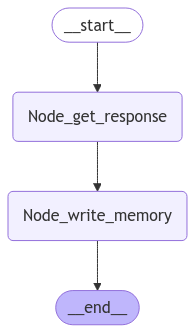

In [35]:
builder = StateGraph(MessagesState)
builder.add_node("Node_get_response", Node_get_response)
builder.add_node("Node_write_memory", Node_write_memory)
builder.add_edge(START, "Node_get_response")
builder.add_edge("Node_get_response", "Node_write_memory")
builder.add_edge("Node_write_memory", END)

# Checkpointer : short-term (within-thread) memory
ShortTermMemory = MemorySaver()

# Compile the graph with the checkpointer fir and store
graph = builder.compile(checkpointer=ShortTermMemory, 
                        store=LongTermMemory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## Test Chat 

1. Short-Term (within-thread) memory
- thread ID
2. Long-Term (cross-thread) memory
- user ID

Set Configuration
- Thread : initial_chat
- User : changwoo

In [37]:
config = {"configurable": {"thread_id": "initial_chat", 
                           "user_id": "changwoo"}}

Chat (1) Tell my Name

In [38]:
# Run
for chunk in graph.stream({"messages": [HumanMessage(content="Hi, my name is changwoo")]}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

Hi, my name is changwoo
================================== Ai Message ==================================

Hello, Changwoo! It's nice to meet you. How can I assist you today?


Chat (2) Tell my Job

In [39]:
# Run
for chunk in graph.stream({"messages": [HumanMessage(content="I'm Phd Student in Pusan National University")]}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I'm Phd Student in Pusan National University
================================== Ai Message ==================================

That's great to hear, Changwoo! Pursuing a PhD is a significant achievement. What are you studying at Pusan National University?


Chat (3) Tell my major

In [40]:
# Run
message = """I have been studyin Artificial Intelligence, especially in Large Language Model"""
for chunk in graph.stream({"messages": [HumanMessage(content=message)]}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I have been studyin Artificial Intelligence, especially in Large Language Model
================================== Ai Message ==================================

That's fascinating, Changwoo! Large Language Models are a rapidly evolving area in AI with a lot of exciting developments. Are you working on any specific projects or research questions related to Large Language Models?


Check Short-Term Memory (within-thread)

In [42]:
thread = {"configurable": {"thread_id": "initial_chat"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()

================================ Human Message =================================

Hi, my name is changwoo
================================== Ai Message ==================================

Hello, Changwoo! It's nice to meet you. How can I assist you today?
================================ Human Message =================================

I'm Phd Student in Pusan National University
================================== Ai Message ==================================

That's great to hear, Changwoo! Pursuing a PhD is a significant achievement. What are you studying at Pusan National University?
================================ Human Message =================================

I have been studyin Artificial Intelligence, especially in Large Language Model
================================== Ai Message ==================================

That's fascinating, Changwoo! Large Language Models are a rapidly evolving area in AI with a lot of exciting developments. Are you working on any specific project

Check Long-Term Memory (cross-thread)

In [43]:
NAMESPACE = ("memories", "changwoo") 
key = "chat_user_memory" # personal_info, Education_level
existing_memory = LongTermMemory.get(NAMESPACE, key)
existing_memory.dict()

{'value': {'memory': "**Updated User Information:**\n- User's name is Changwoo.\n- Changwoo is a PhD student at Pusan National University.\n- Changwoo is studying Artificial Intelligence, with a focus on Large Language Models."},
 'key': 'chat_user_memory',
 'namespace': ['memories', 'changwoo'],
 'created_at': '2024-11-27T06:27:33.957232+00:00',
 'updated_at': '2024-11-27T06:27:49.952595+00:00'}

Set Configuration
- Thread : second_chat
- User : changwoo

In [44]:
config = {"configurable": {"thread_id": "second_chat", 
                           "user_id": "changwoo"}}

Chat (1) Tell my age, family

In [45]:
message = """I'm 29 years old. I have a family of 7. Recently, a cute niece was born."""
for chunk in graph.stream({"messages": [HumanMessage(content=message)]}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I'm 29 years old. I have a family of 7. Recently, a cute niece was born.
================================== Ai Message ==================================

Thank you for sharing more about yourself, Changwoo! It's wonderful to hear about your growing family and the arrival of your cute niece. If there's anything specific you'd like to discuss or need help with, feel free to let me know!


Chat (2) Tell my hobby

In [46]:
# Run
message = """My hobby is working out at the gym. I have been doing it for 2 years."""
for chunk in graph.stream({"messages": [HumanMessage(content=message)]}, 
                          config, 
                          stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

My hobby is working out at the gym. I have been doing it for 2 years.
================================== Ai Message ==================================

That's great to hear, Changwoo! Working out at the gym is a fantastic way to stay healthy and relieve stress, especially with the demands of your PhD studies. Since you've been doing it for 2 years, you must have developed a solid routine by now. If you ever want to share more about your workout routine or need tips on anything related to fitness, feel free to ask!


Check Short-Term Memory (within-thread)

In [48]:
thread = {"configurable": {"thread_id": "second_chat"}}
state = graph.get_state(thread).values
for m in state["messages"]: 
    m.pretty_print()
    # print(m.content)

================================ Human Message =================================

I'm 29 years old. I have a family of 7. Recently, a cute niece was born.
================================== Ai Message ==================================

Thank you for sharing more about yourself, Changwoo! It's wonderful to hear about your growing family and the arrival of your cute niece. If there's anything specific you'd like to discuss or need help with, feel free to let me know!
================================ Human Message =================================

My hobby is working out at the gym. I have been doing it for 2 years.
================================== Ai Message ==================================

That's great to hear, Changwoo! Working out at the gym is a fantastic way to stay healthy and relieve stress, especially with the demands of your PhD studies. Since you've been doing it for 2 years, you must have developed a solid routine by now. If you ever want to share more about your workou

Check Long-Term Memory (cross-thread)

In [49]:
NAMESPACE = ("memories", "changwoo")
key = "chat_user_memory"
existing_memory = LongTermMemory.get(NAMESPACE, key)
existing_memory.dict()

{'value': {'memory': "**Updated User Information:**\n- User's name is Changwoo.\n- Changwoo is a PhD student at Pusan National University.\n- Changwoo is studying Artificial Intelligence, with a focus on Large Language Models.\n- Changwoo is 29 years old.\n- Changwoo has a family of 7 members.\n- Changwoo recently had a niece born.\n- Changwoo's hobby is working out at the gym, which he has been doing for 2 years."},
 'key': 'chat_user_memory',
 'namespace': ['memories', 'changwoo'],
 'created_at': '2024-11-27T06:27:33.957232+00:00',
 'updated_at': '2024-11-27T06:28:43.330066+00:00'}